# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np

try:
  import lightgbm as lgb
except:
  !pip install lightgbm
  import lightgbm as lgb
  
try:
  import shap
except:
  !pip install shap
  import shap

try:
  from umap import UMAP
except:
  !pip install umap
  !pip install umap-learn
  from umap import UMAP

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-13 14:47:51.505994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 14:47:51.738433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 14:47:51.740166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:47:53.219083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [2]:
!pwd

/home/vbettachini/documents/universitet/FCEyN/maestríaDatos/economíaFinanzas/dmeyf2023/zweite


In [3]:
ds_train = pd.read_csv("~/buckets/b1/datasets/competencia_02_eng.csv.gz")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos **BAJA+2**. Sacamos los de los **datasets** los targets.

In [4]:
ds_bajas = ds_train.query("clase_ternaria == 'BAJA+2'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [5]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.049542,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 7585,
    'verbose': 0,
}

np.random.seed(874807)
gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)

Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [6]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia

,Features,Importances
0,foto_mes,463
106,ctrx_quarter,165
93,tcallcenter,151
126,Master_fechaalta,136
50,cpayroll_trx,130
...,...,...
65,mcajeros_propios_descuentos,0
64,ccajeros_propios_descuentos,0
63,mpagomiscuentas,0
62,cpagomiscuentas,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [7]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
lgbm_importancia.to_pickle("~/buckets/b1/datasets/lgbm_importancia_02.pkl")
shap_bajas.to_pickle("~/buckets//b1/datasets/shap_bajas_02.pkl")

In [ ]:
import os
import pickle
file_path = os.path.expanduser("~/buckets/b1/datasets/shap_values_02")
with open(file_path, "wb") as fp:   #Pickling
    pickle.dump(shap_values, fp)

In [ ]:
file_path = os.path.expanduser("~/buckets/b1/datasets/p_bajas_02.npy")
np.save(file_path, p_bajas)

En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
# busco un caso en p_bajas, con un p alta, y tomo su índice
cliente_idx = 7 # el 
print(p_bajas[cliente_idx])

0.008558372846891434


En la columna de la izquierda es el valor de la variable, la importancia es la columna derecha.
Cuanto más positivo ese parámetro es más determinate a que se produzca la baja+2, uno negativo es que hace menos probable la baja.

In [9]:
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
# pd.concat([ds_bajas.iloc[7], shap_bajas.iloc[7]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

,618,7
ctrx_quarter,56.00,0.125811
mrentabilidad_annual,31990.93,0.108891
tcallcenter,0.00,0.043561
Master_fechaalta,749.00,0.042620
mpasivos_margen,1509.62,0.034816
...,...,...
Visa_mfinanciacion_limite,202694.40,-0.021947
mpayroll,0.00,-0.024392
foto_mes,202103.00,-0.035893
cpayroll_trx,0.00,-0.040703


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [10]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

Master_fechaalta               0.901633
ctrx_quarter                   0.347208
foto_mes                       0.335852
Master_Fvencimiento            0.249326
Visa_mpagospesos               0.177235
                                 ...   
ctarjeta_visa_descuentos       0.000000
mcajeros_propios_descuentos    0.000000
ccajeros_propios_descuentos    0.000000
mpagomiscuentas                0.000000
mforex_buy                     0.000000
Length: 153, dtype: float64

La biblioteca contiene útiles herramientas para vizualizar la info anterior.

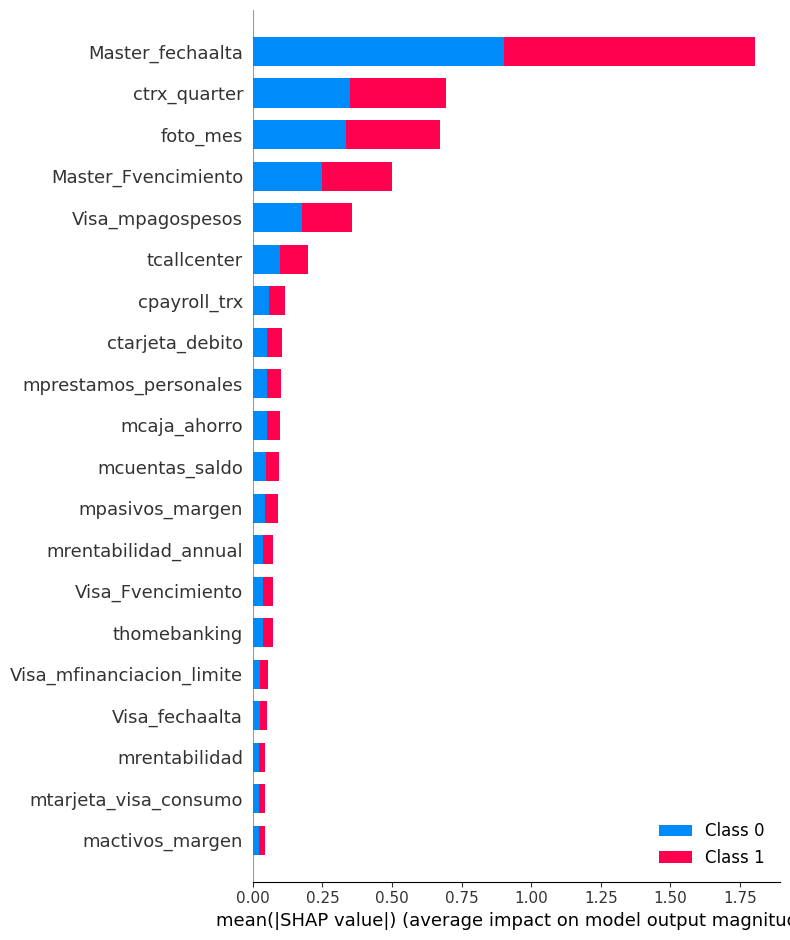

In [11]:
shap.summary_plot(shap_values, ds_bajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

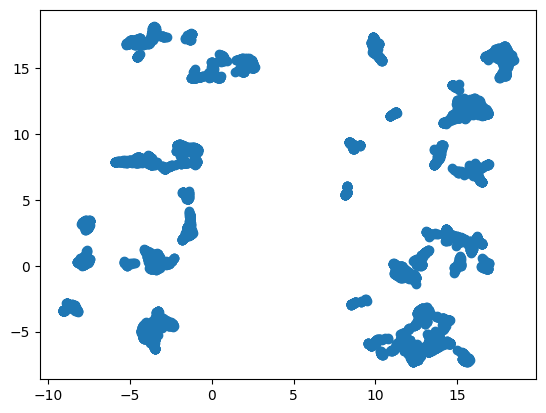

In [12]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([3057.,  902.,  733.,  541.,  656.,  519.,  407.,  232.,   45.,
          36.]),
 array([0.00656085, 0.07108029, 0.13559973, 0.20011918, 0.26463862,
        0.32915806, 0.3936775 , 0.45819694, 0.52271638, 0.58723583,
        0.65175527]),
 <BarContainer object of 10 artists>)

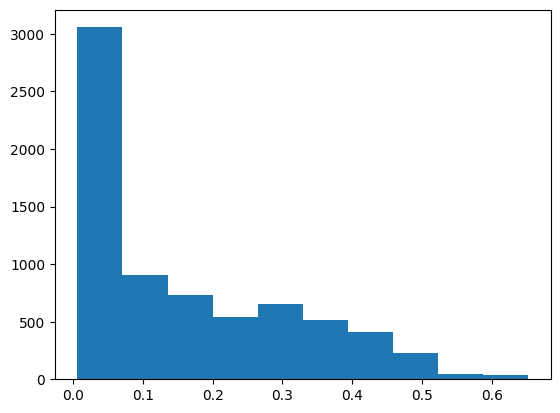

In [13]:
p_bajas = gbm.predict(ds_bajas)
plt.hist(p_bajas)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

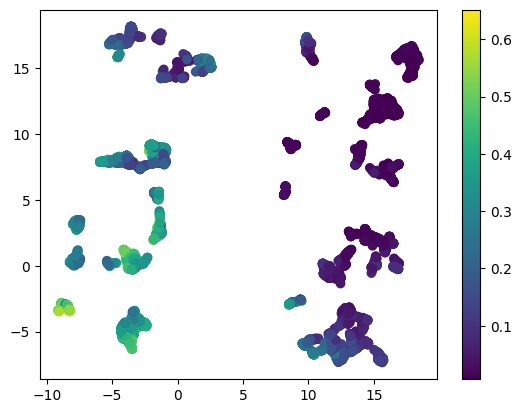

In [14]:
# mayor probabilidades de baja+2 mostrada en escala de colores
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()

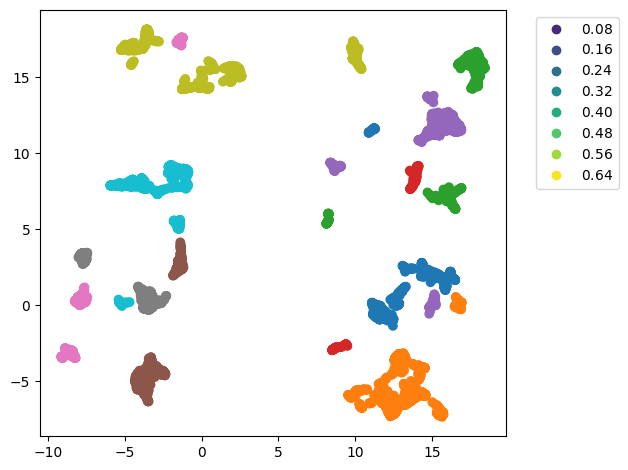

In [15]:
hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [16]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

Master_fechaalta               0.038216
mprestamos_personales          0.016320
tcallcenter                    0.012806
Master_Fvencimiento            0.011993
ctarjeta_visa_transacciones    0.004670
                                 ...   
mpasivos_margen               -0.030778
cpayroll_trx                  -0.059715
mcaja_ahorro                  -0.068566
foto_mes                      -0.206639
ctrx_quarter                  -0.490277
Length: 153, dtype: float64

In [23]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

Master_Fvencimiento         0.206858
thomebanking                0.004873
cdescubierto_preacordado    0.003349
ctarjeta_master             0.003252
cliente_edad                0.002163
                              ...   
cpayroll_trx               -0.044144
mpasivos_margen            -0.046556
Visa_mpagospesos           -0.065261
Master_fechaalta           -0.213952
ctrx_quarter               -0.589793
Length: 153, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

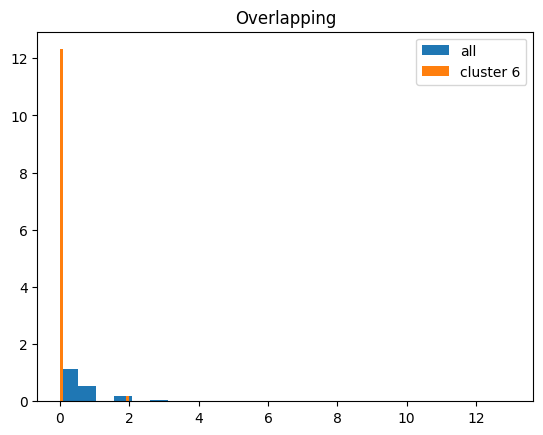

In [22]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 6]["cpayroll_trx"], label='cluster 6', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [24]:
ds_bajas.loc[y.labels_ == 1]["cprestamos_personales"].mean()

0.9801699716713881

In [26]:
ds_bajas.loc[y.labels_ == 5]["cprestamos_personales"].mean()

0.1867881548974943

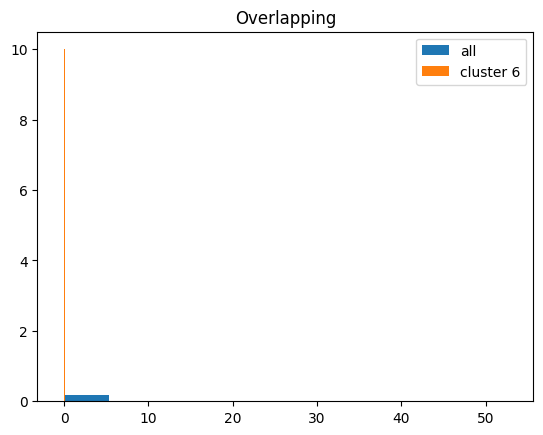

In [27]:
plt.hist(ds_bajas.loc[:]["cprestamos_personales"], label='all', density=True)
plt.hist(ds_bajas.loc[y.labels_ == 6]["cprestamos_personales"], label='cluster 6', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()